In [322]:
import torch
import pandas as pd

labels_url = "https://github.com/MengtingWan/oscar/raw/master/data/df_labels.csv"
features_url = "https://github.com/MengtingWan/oscar/raw/master/data/df_features.csv"
titles_url = "https://github.com/MengtingWan/oscar/raw/master/data/titles.json"
df_labels = pd.read_csv(labels_url, on_bad_lines='skip')
df_features = pd.read_csv(features_url)
df_titles = pd.read_json(titles_url, lines=True)

In [315]:
df_labels['year'].max()

2021

In [3]:
df_labels['primaryNomineeCode'] = df_labels['primaryNomineeCode'].str.slice(2,-2)
df_labels['primaryNomineeName'] = df_labels['primaryNomineeName'].str.slice(2,-2)
df_labels['secondaryNomineeCode'] = df_labels['secondaryNomineeCode'].str.slice(2,-2)
df_labels['secondaryNomineeName'] = df_labels['secondaryNomineeName'].str.slice(2,-2)
df_labels.head(5)

,eventName,eventId,year,awardName,categoryName,newCategoryName,primaryNomineeName,primaryNomineeCode,secondaryNomineeName,secondaryNomineeCode,awardNominationId,isWinner,string
0,"Academy Awards, USA",ev0000003,1990,Oscar,Best Actor in a Leading Role,Best Performance by an Actor in a Leading Role,Daniel Day-Lewis,nm0000358,My Left Foot,tt0097937,an0052711,True,"{""primaryNominees"": [""nm0000358""], ""secondaryN..."
1,"Academy Awards, USA",ev0000003,1990,Oscar,Best Actor in a Leading Role,Best Performance by an Actor in a Leading Role,Kenneth Branagh,nm0000110,Henry V,tt0097499,an0052712,False,"{""primaryNominees"": [""nm0000110""], ""secondaryN..."
2,"Academy Awards, USA",ev0000003,1990,Oscar,Best Actor in a Leading Role,Best Performance by an Actor in a Leading Role,Morgan Freeman,nm0000151,Driving Miss Daisy,tt0097239,an0052714,False,"{""primaryNominees"": [""nm0000151""], ""secondaryN..."
3,"Academy Awards, USA",ev0000003,1990,Oscar,Best Actor in a Leading Role,Best Performance by an Actor in a Leading Role,Robin Williams,nm0000245,Dead Poets Society,tt0097165,an0052715,False,"{""primaryNominees"": [""nm0000245""], ""secondaryN..."
4,"Academy Awards, USA",ev0000003,1990,Oscar,Best Actor in a Leading Role,Best Performance by an Actor in a Leading Role,Tom Cruise,nm0000129,Born on the Fourth of July,tt0096969,an0052713,False,"{""primaryNominees"": [""nm0000129""], ""secondaryN..."


In [323]:
df_data = df_features
df_data['category'] = df_labels['newCategoryName']
df_data['genre'] = df_titles['genre']
df_data['year'] = df_labels['year']
df_data['label'] = df_labels['isWinner'].astype(int)
df_data['user_rating'] = df_titles['rating_score_user']
df_data['critic_rating'] = df_titles['rating_score_critic']
df_data = df_data.dropna()
df_data.shape

(1084, 2276)

In [32]:
combined_features = [] 
for row_x in df_titles.itertuples():
    for row_y in df_labels.itertuples():
        if row_x[1] == row_y[10] or row_x[1] == row_y[8]:
            combined_features.append([row_y[1], row_y[3], row_y[4], row_y[5], row_y[6], row_y[7], row_y[9], row_y[12],
                                      row_x[2], row_x[3], row_x[4], row_x[5], row_x[6], row_x[7], row_x[8]])
columns = ['eventName', 'year', 'awardName', 'categoryName', 'newCategoryName', 'primaryNomineeName', 'secondaryNomineeName', 'isWinner',
                                                      'keywords', 'genre', 'rating_score_critic', 'rating_score_user', 'n_rating_user', 'n_review_critic', 'n_review_user']

combined_df = pd.DataFrame(combined_features, columns = columns)
combined_df

,eventName,year,awardName,categoryName,newCategoryName,primaryNomineeName,secondaryNomineeName,isWinner,keywords,genre,rating_score_critic,rating_score_user,n_rating_user,n_review_critic,n_review_user
0,"Academy Awards, USA",2018,Oscar,Best Live Action Short Film,Best Live Action Short Film,The Eleven O'Clock,"Derin Seale', 'Josh Lawson",False,"[psychiatrist, doctor patient relationship, re...","[Short, Comedy]",NaN,7.6,798.0,4.0,10.0
1,"Academy Awards, USA",2001,Oscar,"Best Documentary, Features",Best Documentary Feature,Long Night's Journey Into Day,"Frances Reid', 'Deborah Hoffmann",False,"[title directed by female, apartheid, south af...",[Documentary],85.0,7.1,226.0,7.0,17.0
2,"Academy Awards, USA",2001,Oscar,Best Foreign Language Film,Best International Feature Film,Divided We Fall,,False,"[nazi, jewish, czechoslovakia, theresienstadt ...","[Comedy, Drama, War]",69.0,7.7,4738.0,65.0,49.0
3,"Academy Awards, USA",1998,Oscar,Best Actor in a Leading Role,Best Performance by an Actor in a Leading Role,Dustin Hoffman,Wag the Dog,False,"[black comedy, satire, scandal, political corr...","[Comedy, Drama]",73.0,7.2,75953.0,228.0,144.0
4,"Academy Awards, USA",1998,Oscar,"Best Writing, Screenplay Based on Material Pre...",Best Adapted Screenplay,Wag the Dog,"Hilary Henkin', 'David Mamet",False,"[black comedy, satire, scandal, political corr...","[Comedy, Drama]",73.0,7.2,75953.0,228.0,144.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3419,"Academy Awards, USA",1995,Oscar,Best Art Direction-Set Decoration,Best Achievement in Production Design,The Madness of King George,"Ken Adam', 'Carolyn Scott",True,"[porphyria, king of england, restraint, self d...","[Biography, Comedy, Drama, History]",89.0,7.2,14610.0,59.0,43.0
3420,"Academy Awards, USA",1995,Oscar,"Best Writing, Screenplay Based on Material Pre...",Best Adapted Screenplay,The Madness of King George,Alan Bennett,False,"[porphyria, king of england, restraint, self d...","[Biography, Comedy, Drama, History]",89.0,7.2,14610.0,59.0,43.0
3421,"Academy Awards, USA",1999,Oscar,Best Actress in a Leading Role,Best Performance by an Actress in a Leading Role,Emily Watson,Hilary and Jackie,False,"[sister sister relationship, brief female nudi...","[Biography, Drama, Music]",78.0,7.3,9434.0,108.0,69.0
3422,"Academy Awards, USA",1999,Oscar,Best Actress in a Supporting Role,Best Performance by an Actress in a Supporting...,Rachel Griffiths,Hilary and Jackie,False,"[sister sister relationship, brief female nudi...","[Biography, Drama, Music]",78.0,7.3,9434.0,108.0,69.0


## Data Visualization

<Axes: xlabel='critic_rating', ylabel='user_rating'>

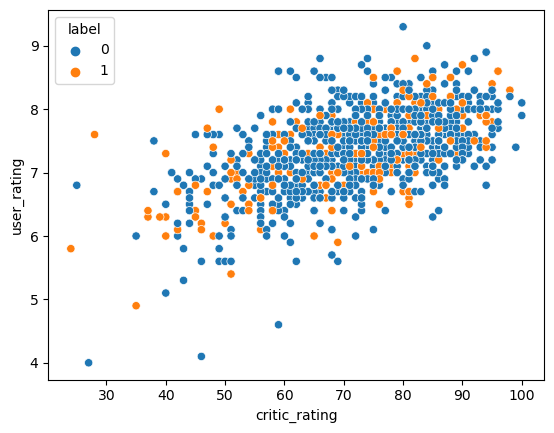

In [248]:
import seaborn as sns

data = df_data[['user_rating', 'critic_rating', 'label']]
sns.scatterplot(data=data, x = 'critic_rating', y = 'user_rating', hue='label')

<Axes: xlabel='rating_score_critic', ylabel='newCategoryName'>

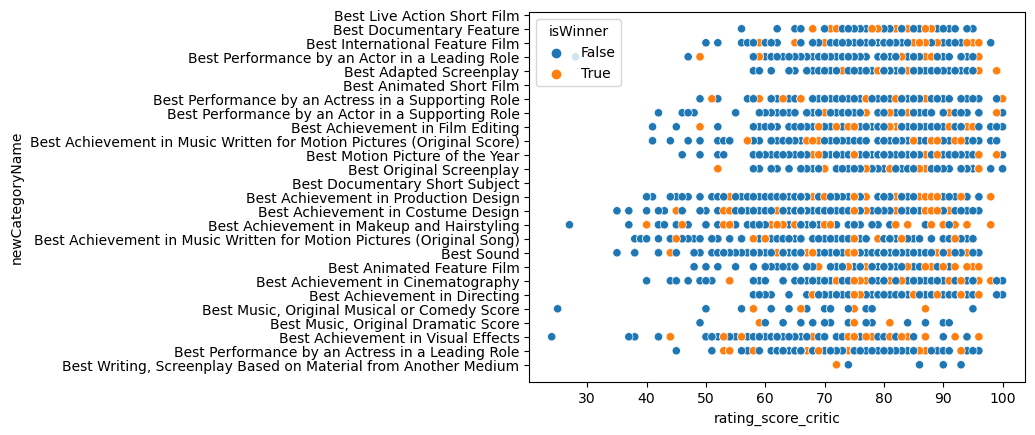

In [10]:
data = combined_df[['rating_score_critic', 'newCategoryName', 'isWinner']]
sns.scatterplot(data=data, x = 'rating_score_critic', y = 'newCategoryName', hue='isWinner')

<Axes: xlabel='rating_score_user', ylabel='newCategoryName'>

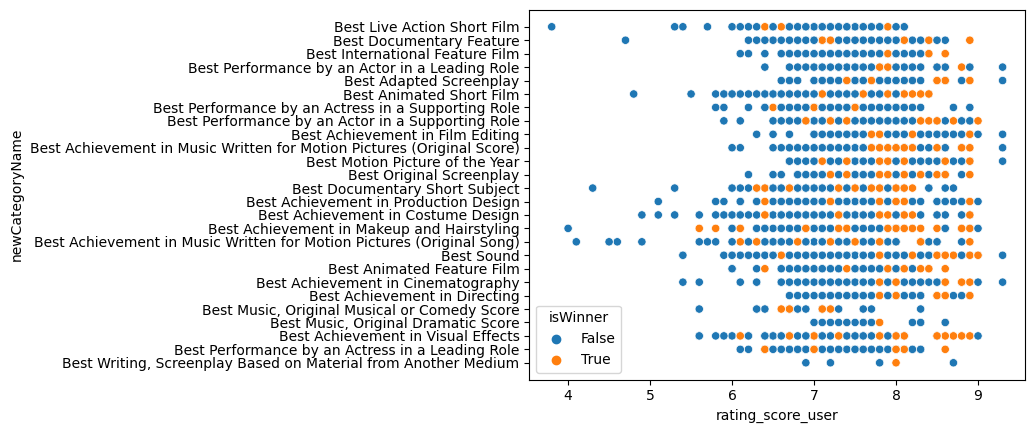

In [11]:
data = combined_df[['rating_score_user', 'newCategoryName', 'isWinner']]
sns.scatterplot(data=data, x = 'rating_score_user', y = 'newCategoryName', hue='isWinner')

In [324]:
new_df = []

for row in df_data.itertuples():
    for genre in row[2272]:
        data_row = list(row)
        data_row[2272] = genre
        new_df.append(data_row)


genre_df = pd.DataFrame(new_df)
genre_df = genre_df.drop(0, axis = 1)
genre_df.columns = df_data.columns
genre_df.head(5)

,BAFTA Awards :: BAFTA Film Award :: Best Actor :: Winner,Golden Globes :: Golden Globe :: Best Performance by an Actor in a Motion Picture - Drama :: Nominated,National Society of Film Critics Awards :: NSFC Award :: Best Actor :: Winner,London Critics Circle Film Awards :: ALFS Award :: Actor of the Year :: Winner,Film Independent Spirit Awards :: Independent Spirit Award :: Best Foreign Film :: Winner,BAFTA Awards :: BAFTA Film Award :: Best Actor in a Supporting Role :: Winner,BAFTA Awards :: BAFTA Film Award :: Best Film :: Nominated,BAFTA Awards :: BAFTA Film Award :: Best Make Up Artist :: Nominated,BAFTA Awards :: BAFTA Film Award :: Best Screenplay (Adapted) :: Nominated,Writers Guild of America :: WGA Award (Screen) :: Best Screenplay Based on Material from Another Medium :: Nominated,...,numRatings,numUserReviews,numCriticReviews,metacriticScore,category,genre,year,label,user_rating,critic_rating
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.134039,-0.368405,-0.011034,0.942712,Best Performance by an Actor in a Leading Role,Documentary,1990,0,7.1,85.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.442578,-0.090014,0.335343,0.917196,Best Performance by an Actor in a Leading Role,Comedy,1990,0,7.7,69.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.442578,-0.090014,0.335343,0.917196,Best Performance by an Actor in a Leading Role,Drama,1990,0,7.7,69.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.442578,-0.090014,0.335343,0.917196,Best Performance by an Actor in a Leading Role,War,1990,0,7.7,69.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.736387,2.250359,0.965120,0.891680,Best Performance by an Actor in a Leading Role,Comedy,1990,0,7.2,73.0


In [203]:
df_data = []

for row in genre_df.itertuples():
    for keyword in row[9]:
        data_row = list(row)
        data_row[9] = keyword
        df_data.append(data_row)


expanded_df = pd.DataFrame(df_data)
expanded_df = expanded_df.drop(0, axis = 1)
expanded_df.columns = columns
expanded_df.head(5)

,eventName,year,awardName,categoryName,newCategoryName,primaryNomineeName,secondaryNomineeName,isWinner,keywords,genre,rating_score_critic,rating_score_user,n_rating_user,n_review_critic,n_review_user
0,"Academy Awards, USA",2018,Oscar,Best Live Action Short Film,Best Live Action Short Film,The Eleven O'Clock,"Derin Seale', 'Josh Lawson",False,psychiatrist,Short,NaN,7.6,798.0,4.0,10.0
1,"Academy Awards, USA",2018,Oscar,Best Live Action Short Film,Best Live Action Short Film,The Eleven O'Clock,"Derin Seale', 'Josh Lawson",False,doctor patient relationship,Short,NaN,7.6,798.0,4.0,10.0
2,"Academy Awards, USA",2018,Oscar,Best Live Action Short Film,Best Live Action Short Film,The Eleven O'Clock,"Derin Seale', 'Josh Lawson",False,receptionist,Short,NaN,7.6,798.0,4.0,10.0
3,"Academy Awards, USA",2018,Oscar,Best Live Action Short Film,Best Live Action Short Film,The Eleven O'Clock,"Derin Seale', 'Josh Lawson",False,word association,Short,NaN,7.6,798.0,4.0,10.0
4,"Academy Awards, USA",2018,Oscar,Best Live Action Short Film,Best Live Action Short Film,The Eleven O'Clock,"Derin Seale', 'Josh Lawson",False,photograph,Short,NaN,7.6,798.0,4.0,10.0


<Axes: xlabel='rating_score_user', ylabel='genre'>

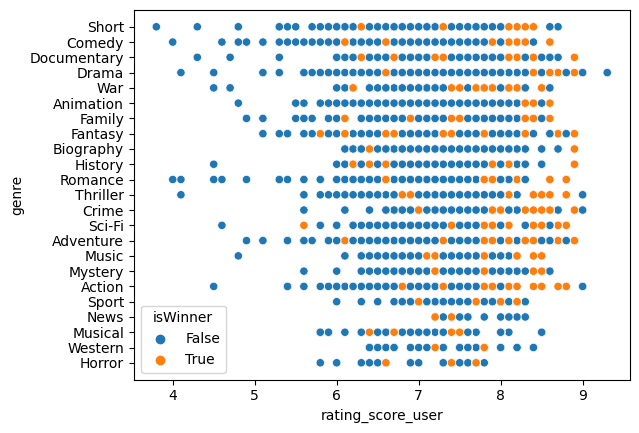

In [41]:
sns.scatterplot(data=genre_df[['genre', 'rating_score_user', 'isWinner']], x='rating_score_user', y='genre', hue='isWinner')

/Users/ethanlavallee/anaconda3/envs/ml-0451/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ethanlavallee/anaconda3/envs/ml-0451/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


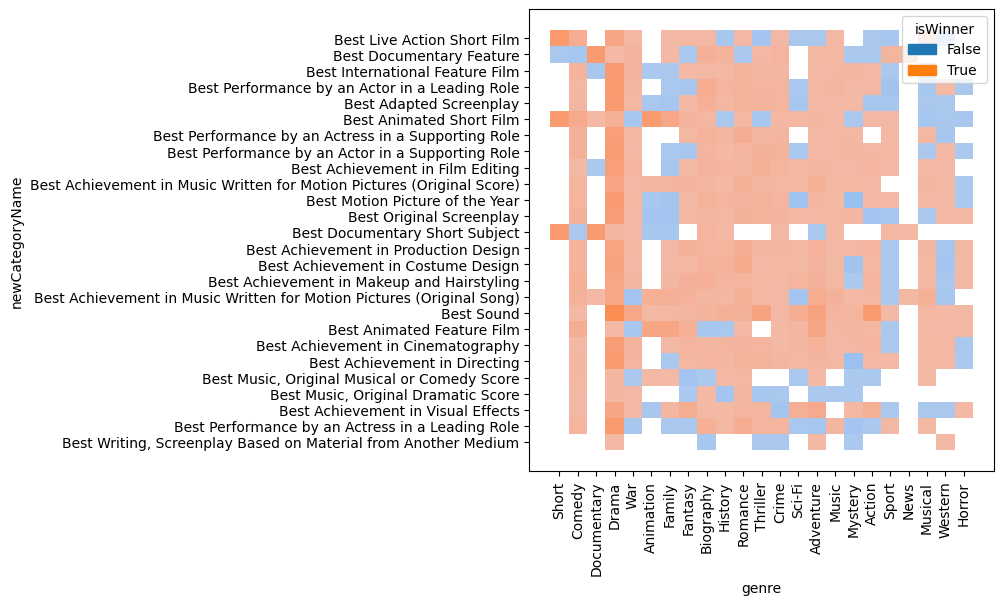

In [51]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(6,6))

sns.histplot(ax=axs, data=genre_df[['genre', 'newCategoryName', 'isWinner']], x='genre', y='newCategoryName', hue='isWinner')
axs.tick_params(axis='x', rotation=90)

In [271]:
genre_df.groupby('label').size()

label
0    2607
1     710
dtype: int64

In [325]:
rand_samp_df = genre_df.groupby('label').sample(710)
rand_samp_df.groupby('label').count()

,BAFTA Awards :: BAFTA Film Award :: Best Actor :: Winner,Golden Globes :: Golden Globe :: Best Performance by an Actor in a Motion Picture - Drama :: Nominated,National Society of Film Critics Awards :: NSFC Award :: Best Actor :: Winner,London Critics Circle Film Awards :: ALFS Award :: Actor of the Year :: Winner,Film Independent Spirit Awards :: Independent Spirit Award :: Best Foreign Film :: Winner,BAFTA Awards :: BAFTA Film Award :: Best Actor in a Supporting Role :: Winner,BAFTA Awards :: BAFTA Film Award :: Best Film :: Nominated,BAFTA Awards :: BAFTA Film Award :: Best Make Up Artist :: Nominated,BAFTA Awards :: BAFTA Film Award :: Best Screenplay (Adapted) :: Nominated,Writers Guild of America :: WGA Award (Screen) :: Best Screenplay Based on Material from Another Medium :: Nominated,...,rating,numRatings,numUserReviews,numCriticReviews,metacriticScore,category,genre,year,user_rating,critic_rating
label,,,,,,,,,,,,,,,,,,,,,
0,710,710,710,710,710,710,710,710,710,710,...,710,710,710,710,710,710,710,710,710,710
1,710,710,710,710,710,710,710,710,710,710,...,710,710,710,710,710,710,710,710,710,710


In [327]:
from sklearn.model_selection import train_test_split
# should use label encoder for genres
feature_df = rand_samp_df[['genre', 'user_rating', 'critic_rating', 'label', 'category', 'year']]
feature_df = feature_df.copy()
feature_df = feature_df.dropna()

In [328]:
featureNames = list(genre_df.columns)
featureNames.remove('label')

In [329]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
tfidf_vectorizer = TfidfVectorizer()


column_transformer = ColumnTransformer(
    transformers=[
        ('genre_ohe', OneHotEncoder(), ['genre']),
        ('category_ohe', OneHotEncoder(), ['category']),
    ],
    remainder='passthrough',
    sparse_threshold=0
)

pipeline = Pipeline([
    ('encoder', column_transformer),
    ('regressor', LogisticRegression(max_iter=5000))
])

train_df, test_df = train_test_split(rand_samp_df, test_size=0.2)
X_train = train_df[featureNames]
y_train = train_df['label']

X_test  = test_df[featureNames]
y_test  = test_df['label']

pipeline.fit(X_train, y_train)


Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('genre_ohe', OneHotEncoder(),
                                                  ['genre']),
                                                 ('category_ohe',
                                                  OneHotEncoder(),
                                                  ['category'])])),
                ('regressor', LogisticRegression(max_iter=5000))])

In [330]:
pipeline.score(X_train, y_train)

0.886443661971831

In [331]:
from sklearn.model_selection import cross_val_score
cv_scores_LR = cross_val_score(pipeline, X_train, y_train, cv = 5)
cv_scores_LR.mean()


0.7508424144060593

In [332]:
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.2007042253521127


In [333]:
train_preds = (1.0*(pipeline.predict(X_train) == y_train)).mean()
test_preds  = (1.0*(pipeline.predict(X_test) == y_test)).mean()

print(f'Train prediction success: {train_preds}')
print(f'Test prediction success: {test_preds}')

Train prediction success: 0.886443661971831
Test prediction success: 0.7992957746478874


In [334]:
from sklearn.metrics import confusion_matrix

train_predictions  = (1.0*(pipeline.predict(X_train) == y_train))
confusion_matrix(y_train, train_predictions, normalize="true")

array([[0.11033275, 0.88966725],
       [0.11681416, 0.88318584]])

In [336]:
train_predictions.sum()

1007.0

In [337]:
len(train_predictions)

1136

In [305]:
X_test_genres = X_test['genre']
X_test_genres

887         Drama
1126       Action
2219    Biography
2651       Sci-Fi
1384        Crime
          ...    
190     Biography
152         Drama
1920        Drama
2218      Western
568         Drama
Name: genre, Length: 284, dtype: object

In [316]:
test_predictions  = (1.0*(pipeline.predict(X_test) == y_test))
train_predictions  = (1.0*(pipeline.predict(X_train) == y_train))

<Axes: xlabel='label', ylabel='genre'>

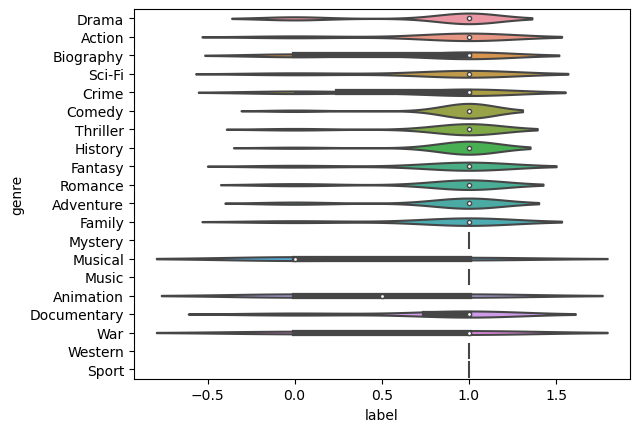

In [307]:
sns.violinplot(x=test_predictions, y=X_test_genres)

In [320]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, train_predictions, normalize="true")

array([[0.12234043, 0.87765957],
       [0.12412587, 0.87587413]])

From this we have an 87% false negative rate, but an 87% true negative rate